### Neuropixels
Version 04-08-2024
Written by Yousuf El-Jayyousi. Adapted by LC and Yunchang

This notebook is split into 4 parts:

**1) Visualizing data and understanding the experiment.** If you are confused about the experiment, look at the linked paper. You should use this portion of the notebook to help yourself understand the structure of the data. There are also some blocks of code that might be useful for creating *raw data plots* for your figure submission.

**2) T-tests.** In this portion, you will determine whether each recorded neuron is more active during trials in which the mouse chose to turn left vs. trials in which the mouse chose to turn right. You will conduct a t-test to compare the firing rates of neurons during each type of trial (left choice vs. right choice). This analysis will determine which cells prefer right choice, left choice, and which show no preference. *This analysis is useful for splitting your neurons into left-preferring and right-preferring, but is not in itself a sufficient scope for your figure project.*

**3) Logistic regression repeated for each time bin.** In this section, you will be able to answer the question, *"Does the ability to decode mouse choice (turning left vs. right at the end of a t-maze) change across the course of a trial?".*

**4) Logistic regression repeated for each neuron.** In this section, you will be able to answer the question, *"Does the ability to decode mouse choice (turning left vs. right at the end of a t-maze) differ between neurons?"*.

**5) Figure ideas**

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split


In [2]:
# this may be useful for relabeling axes with task phases
# only works for plots in which there are 67 time bins along the x-axis
def trial_xticks(ax, bin_sizes=[5, 25, 15, 7, 15], labels = ["S", "Cue", "Delay", "Arm", "Reward"], tick_length=15):
    bin_locs = np.cumsum(bin_sizes)
    ax.set_xticks([0] + bin_locs.tolist())
    ax.set_xticklabels([])
    ax.tick_params("x", length=tick_length, width=1, which="major")
    ax.set_xlabel("Time", labelpad=10)

    periods = labels
    for i in range(5):
        xloc = ([0] + bin_locs.tolist())[i] + bin_sizes[i] / 2
        ax.text(
            xloc,
            -0.03,
            periods[i],
            fontsize=10,
            horizontalalignment="center",
            verticalalignment="top",
            transform=ax.get_xaxis_transform(),
            rotation=0,
        )

## **Section 1: Understanding the experiment and visualizing raw dat**a

## Neuropixels during Towers Task
This next dataset comes from the towers task in the Witten lab. In the experiment [detailed here](https://www.nature.com/articles/s41593-022-01021-9), mice run down a virtual reality corridor (a T-maze) as towers appear left and right. At the end of the corridor, they must decide whether to turn left or right and should make their decision according to which side had more towers ("evidence") appear in order to receive liquid reward. Neuropixel probes were implanted in the dorsomedial striatum (known to be heavily involved in decision making). The indirect pathway of the right striatum was also optogenetically inhibited on 20% of trials during the cue period. Due to each trial having different lengths, the spike rate was resampled relative to each phase of the task such that each trial is 67 time points [method detailed here](https://www.sciencedirect.com/science/article/pii/S0896627321008357?via%3Dihub#sec4). The task phases are:
- Start - very small section at the beginning of the track
- Cue - the section of track in which towers appear
- Delay - a section of track before making a decision that has no cues
- Arm Enter - the period in which the mouse enters either the left or right arm of the maze
- Outcome - the period in which the mouse receives reward or aversive stimulus



## Open the file and explore the data shape
Here are some details about they keys in the data file that might be of interest for your analysis (you won't necessarily need to use all of them):
- "timeSqueezedFR": contains spike rate activity from 173 neurons on each trial. This has already been downsampled to the 67 time bins.
  - the number of bins per task phase are (same order as listed above): 5, 25, 15, 7, 15
- "choice": 0 for left, 1 for right
- "reward": 1 if rewarded, 0 otherwise
- "trialType": what the correct choice was
- "nCues_RminusL": number of cues/towers on the right side minus left side. This can tell you the difficulty of a trial (i.e. values close to 0 are the most difficult typically)
- "laser": 1 if optogentic inhibition was present on that trial, 0 otherwise.

Note: a possible analysis route that this notebook doesn't cover is whether inhibition has an effect. We expect that inhibition of the indirect pathway to give contralateral bias on left/right decisions. This would mean a tendancy to choose left since the inhibition is on the right side. You could explore the effect of this behaviorally and on the neurons, but know that the effect might be small as this is a single session.

Some other keys that might be relevant for a "raw figure":
- "spikes": this is a list in which each element contains the spike times for a neuron throughout the session (in seconds)
- "trialStart": start time of each trial (in seconds)
- "trialEnd": end time of each trial (in seconds)

You'll also see a cell below which will load a few \*taskEvent\*_start values for each trial. No need to worry about the indexing in this cell, just know what the variables are (the time in the session at which the event occured)!

In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [5]:
# this block loads the example data.
file = './test_data_dms_ind_492_0603.pickle' # change file path
with open(file, 'rb') as f:
    data = pickle.load(f)
data['reward'] = data['choice'] == data['trialType']

fr = np.array(data['timeSqueezedFR'])

print(fr.shape)
print(data.keys())
print(f'n_neurons: {fr.shape[0]}, n_trials: {fr.shape[1]}, n_timepoints: {fr.shape[2]}')

(173, 258, 67)
dict_keys(['nCues_RminusL', 'currMaze', 'laserON', 'trialStart', 'trialEnd', 'keyFrames', 'time', 'cueOnset_L', 'cueOnset_R', 'choice', 'trialType', 'pos', 'spikes', 'timeSqueezedFR', 'reward'])
n_neurons: 173, n_trials: 258, n_timepoints: 67


In [6]:
# This block determines times that different sections of a trial (cue, delay, arm, outcome) begin. You will not need to change this code.
cue_start = []
delay_start = []
arm_start = []
outcome_start = []
for i in range(len(data['keyFrames'])):
    keys = data['keyFrames'][i].astype(int)
    t = data['trialStart'][i]
    cue_start.append(data['time'][i][keys[0]] + t)
    delay_start.append(data['time'][i][keys[1]] + t)
    arm_start.append(data['time'][i][keys[2]] + t)
    outcome_start.append(data['time'][i][keys[3]] + t)
cue_start = np.array(cue_start)
delay_start = np.array(delay_start)
arm_start = np.array(arm_start)
outcome_start = np.array(outcome_start)

# Let's visualize some raw data!



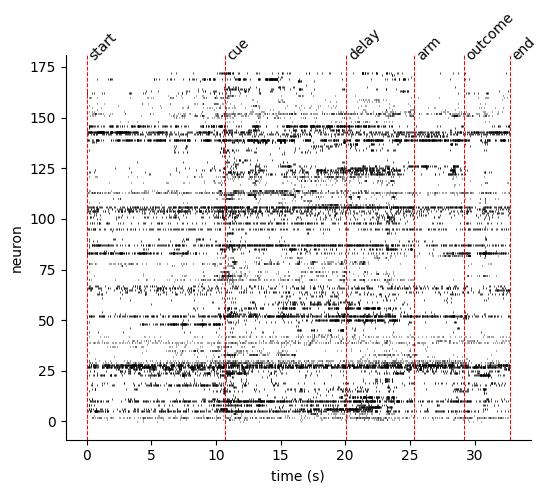

In [7]:
# the session is over an hour long, so let's just visualize one trial

trial = 1 # change this value if you want to visualize a different trial

start_time = data['trialStart'][trial]
end_time = data['trialEnd'][trial]
n_neurons = len(data['spikes'])

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# drawing vertical lines for spikes for each neuron
for i in range(n_neurons):
    # find which spikes are in the time range
    spike_idx = (data['spikes'][i] > start_time) * (data['spikes'][i] < end_time)

    # draw a vertical line for each spike
    ax.vlines(data['spikes'][i][spike_idx] - start_time, i-0.4, i+0.4, color='k', lw=0.5)


task_events = [start_time, cue_start[trial], delay_start[trial], arm_start[trial], outcome_start[trial], end_time]
task_events_lbls = ['start', 'cue', 'delay', 'arm', 'outcome', 'end']

# label the task events
for event, lbl in zip(task_events, task_events_lbls):
    ax.axvline(event - start_time, color='r', linestyle='--', lw=0.75)
    ax.text(event - start_time, n_neurons+4, lbl, rotation=45, va='bottom', ha='left')
ax.set_ylabel('neuron')
ax.set_xlabel('time (s)')
sns.despine()

# Section 2: t-test to identify left- vs. right- preferring neurons

In the following cells, we'll take you through identifying which neurons show a preference for left or right choices by t-testing their max firing rate on each trial.

In [18]:
# here we will calculate a z-score to normalize each neuron's firing rate

#creating a copy of our firing rate variable
fr_z = fr.copy()
# z-scoring each neuron's firing rate
for i in range(fr.shape[0]):
    fr_z[i] = zscore(fr[i], axis=None)

### Let's first visualize the spike rate for all neurons

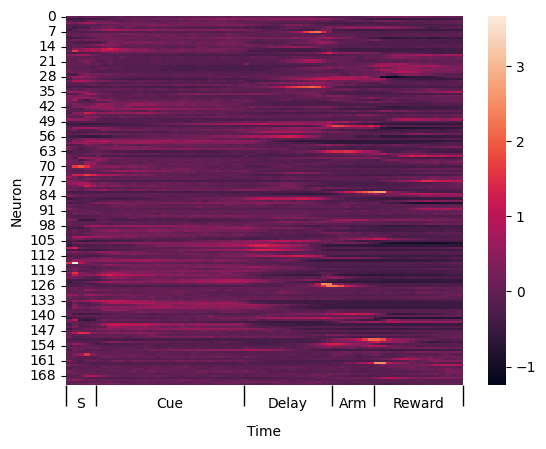

In [19]:
# plotting the mean firing rate of each neuron across trials
fr_avg = fr_z.mean(axis=1)
sns.heatmap(fr_avg)
plt.xlabel('Time')
plt.ylabel('Neuron')
trial_xticks(plt.gca())

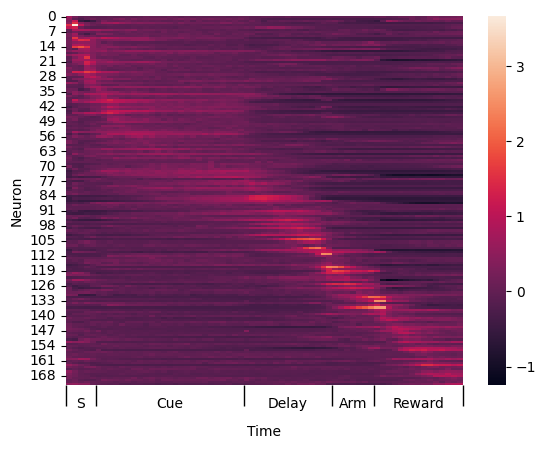

In [20]:
# sorting neurons by the max of their average firing rate across trials
# This visualization helps us to get a feel for how many neurons are firing during different parts of the trial
sort_idx = np.argsort(np.argmax(fr_avg, axis=1))
sns.heatmap(fr_avg[sort_idx], square=False)
plt.xlabel('Time')
plt.ylabel('Neuron')
trial_xticks(plt.gca())

### now, for the t-test:

Remember, here we are determining which neurons preferentially fire during trials that result in a leftward vs rightward choice. We first calculate a maximum firing rate for each trial for each neuron. Then, we compare the maximum firing rates across trials that resulted in a rightward choice to the trials that resulted in a leftward choice using a t-test.

In [21]:
# indexing each neuron at its avg peak firing time bin across all trials
max_resp = fr[np.arange(173), :, np.argmax(fr_avg, axis=1)]

# getting max response for left and right choices
max_resp_l = max_resp[:, data['choice'] == 0] # max response for left
max_resp_r = max_resp[:, data['choice'] == 1] # max response for right

# t test
from scipy.stats import ttest_ind
t, p = ttest_ind(max_resp_l, max_resp_r, axis=1) # compare max response for left vs. right across trials
print(f'{(p<0.05).sum()} neurons are significantly different between left and right choices')


left_pref_idx = np.where((p<0.05) & (t>0))[0] # determine where p-value is significant and t-stat is positive (meaning left mean is greater than right mean)
right_pref_idx = np.where((p<0.05) & (t<0))[0] # repeat for right
non_pref_idx = np.where(p>0.05)[0] # consider non-significant cells to be non-preferential

n_lefties = len(left_pref_idx)
n_righties = len(right_pref_idx)
n_non_pref = len(non_pref_idx)

print(f'{n_lefties} neurons prefer left, {n_righties} neurons prefer right, {n_non_pref} neurons are non-preferential')

83 neurons are significantly different between left and right choices
46 neurons prefer left, 37 neurons prefer right, 90 neurons are non-preferential


At this point we have a measure of which cells fire significantly faster during trials in which the mouse choose right vs. left. The next few blocks of code help us to visualize this relationship. To explore whether we can decode the stimulus (either right or left choice, or correct or incorrect choice), check out the GLM approach a few blocks down.

### now let's **visualize** this to see how their firing patterns look different on left and right trials

Note that you could also visualize firing rate of left vs. right preferring in rewarded vs. unrewarded trials but changing 'choice' to 'reward' in the block below.


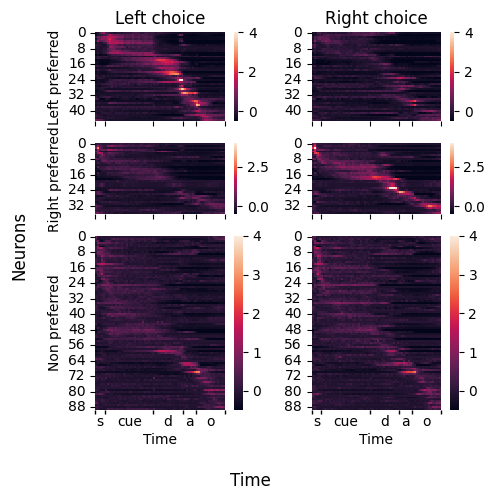

In [22]:
fig, axs = plt.subplots(3, 2, figsize=(5, 5), sharex=True, gridspec_kw={'height_ratios': [n_lefties, n_righties, n_non_pref]})

# getting the firing rate of left, right, and non-preferred neurons
fr_lp = fr_z[left_pref_idx]
fr_rp = fr_z[right_pref_idx]
fr_np = fr_z[non_pref_idx]

# getting the avg firing rate on left vs right choices for each neuron type
# key:
# fr = firing rate
# lp = left preferred
# rp = right preferred
# np = non preferred
# left = left choice
# right = right choice
fr_lp_left = fr_lp[:, data['choice'] == 0, :].mean(axis=1)
fr_lp_right = fr_lp[:, data['choice'] == 1, :].mean(axis=1)
fr_rp_left = fr_rp[:, data['choice'] == 0, :].mean(axis=1)
fr_rp_right = fr_rp[:, data['choice'] == 1, :].mean(axis=1)
fr_np_left = fr_np[:, data['choice'] == 0, :].mean(axis=1)
fr_np_right = fr_np[:, data['choice'] == 1, :].mean(axis=1)

# again sorting neurons by the max of their average firing rate across trials
lp_sort = np.argsort(np.argmax(fr_lp.mean(axis=1), axis=1))
rp_sort = np.argsort(np.argmax(fr_rp.mean(axis=1), axis=1))
np_sort = np.argsort(np.argmax(fr_np.mean(axis=1), axis=1))


# plotting all of the above
# be sure to appropirately set the vmin and vmax values so that you can tell the difference between the plots!
vmin = -0.5
vmax = 4
square = True

sns.heatmap(fr_lp_left[lp_sort], ax=axs[0, 0], vmin=vmin, vmax=vmax, square=square)
sns.heatmap(fr_lp_right[lp_sort], ax=axs[0, 1], vmin=vmin, vmax=vmax, square=square)
sns.heatmap(fr_rp_left[rp_sort], ax=axs[1, 0], vmin=vmin, vmax=vmax, square=square)
sns.heatmap(fr_rp_right[rp_sort], ax=axs[1, 1], vmin=vmin, vmax=vmax, square=square)
sns.heatmap(fr_np_left[np_sort], ax=axs[2, 0], vmin=vmin, vmax=vmax, square=square)
sns.heatmap(fr_np_right[np_sort], ax=axs[2, 1], vmin=vmin, vmax=vmax, square=square)

fig.supxlabel('Time')
fig.supylabel('Neurons')

axs[0, 0].set_title('Left choice')
axs[0, 1].set_title('Right choice')
axs[0, 0].set_ylabel('Left preferred')
axs[1, 0].set_ylabel('Right preferred')
axs[2, 0].set_ylabel('Non preferred')


trial_xticks(axs[2, 0], labels=['s', 'cue', 'd', 'a', 'o'], tick_length=3)
trial_xticks(axs[2, 1], labels=['s', 'cue', 'd', 'a', 'o'], tick_length=3)

plt.tight_layout()

## Possible expansion of the analysis:
Are there neurons that are more active on rewarded vs unrewarded trials? How many? Do any overlap with left/right preferring? What does this brain region seem to primarily be involved in?

# GLM/Logistic Regression (LR) Approach

We can ask similar questions using a regression model in which we use neural activity to predict choice. In a regression model, you create a design matrix that is of shape (n_samples, n_dimensions). In our case, we have a matrix that is (n_neurons, n_trials, n_timepoints). We could treat each time point as a dimension so that we have (n_trials, n_neurons*n_timepoints). However, we end up with about 45 times more dimensions than samples which is a lot of weights to try and fit! Instead we'll break this regression problem up into many small regressions.

In [23]:
# this function will be used later on to obtain credible intervals for
# logistic regression weights. no need to worry about its inner workings!

import torch

def get_std(w, X, y, reg):
    def nll(w):
        r = torch.matmul(X_, w)
        p =  1 / (1 + torch.exp(-r))
        loglikelihood = y_.long() * torch.log(p + 1e-10) + (1 - y_.long()) * torch.log(1 - p + 1e-10)
        nll = -torch.sum(loglikelihood) + reg * torch.sum(w ** 2)
        return nll
    X_ = torch.tensor(X, dtype=torch.float32)
    y_ = torch.tensor(y, dtype=torch.float32)
    w_ = torch.tensor(w, dtype=torch.float32)
    hess = torch.autograd.functional.hessian(nll, w_).squeeze()
    std = torch.sqrt(torch.diag(torch.inverse(hess))).detach().numpy()
    return std

# Section 3: Fitting each time point independently
Here we'll fit a LR model to each time point such that our design matrix is (n_trials, n_neurons) and each element is the neuron's activity on a given trial at time point *t*. So for each *t* there will be a separate matrix. We can then test each timepoint's model for accuracy and see how our ability to decode choice evolves over a trial. What phase of the task seems most relevant to this brain region?

In [24]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler


scores = []

n_timepoints = 67 # fixed value based on structure of data

# looping through each time point
for t in range(n_timepoints):

    # grab the respective time point for each neuron (this is now n_trials x n_neurons)
    X = np.concatenate([i[:, t:(t+1)] for i in data['timeSqueezedFR']], axis=1)
    X[np.isnan(X)] = 0 # make sure we don't have any nans
    X = StandardScaler().fit_transform(X) # z-score each neuron's firing rate
    X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1) # add a bias term

    # X is now our design matrix which includes a bias term (vector of ones) and your predictor variables
    # Change X if you want to restrict your predictors (e.g. only correct trials)

    y = data['choice'] # target variable. Change if you want to use a different response variable (like 'reward')

    # split data into training and testing sets
    # You will not need to change test_size or random_state values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # fit logistic regression model using *training* set
    lr = LogisticRegressionCV(cv=5, max_iter=1000, penalty='l2')
    lr.fit(X_train, y_train)

    # get the accuracy of the model on the *test* set
    scores.append(lr.score(X_test, y_test))
    # scores is now a measure of our ability to decode our target variable for each of the 67 time bins

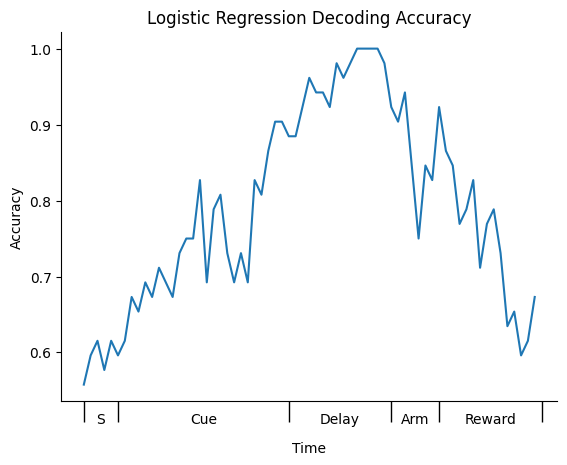

In [26]:
# look at the decoding accuracy over time
plt.plot(np.array(scores))
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Decoding Accuracy')
trial_xticks(plt.gca())
sns.despine()

# Section 4: Fitting each neuron independently
Here we'll fit a LR model to each neuron such that our design matrix is (n_trials, n_timepoints). We can then see which neurons are most predictive of choice and then compare their weights and average activity on left vs right trials.

In [27]:
# this cell might take a few minutes to run
# it combines the code from section 3, differing in the creation of our design matrix (X)
# it also uses the function written above to calculate confidence in our weights

results = []
scores = []
stds = []

n_neurons = len(data['timeSqueezedFR'])
for neuron in range(n_neurons):

    # grab the firing rate for each neuron (this is now n_trials x n_timepoints)
    X = data['timeSqueezedFR'][neuron]
    X[np.isnan(X)] = 0 # make sure we don't have any nans
    X = StandardScaler().fit_transform(X) # z-score each neuron's firing rate
    X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1) # add a bias term

    y = data['choice'] # target variable. This can be changed to look at other outcomes, like correct vs. incorrect trials (use 'reward')

    # split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # fit logistic regression model
    lr = LogisticRegressionCV(cv=5, max_iter=2000, penalty='l2', Cs=np.logspace(-4, 4, 10), fit_intercept=False, random_state=10)
    lr.fit(X_train, y_train)

    # we're also going to calculate the standard deviation of the weights (this is our confidence in the weights)
    # this is a little involved so we've written a function to do it for you
    reg = 1 / lr.C_[0]
    std = get_std(lr.coef_.squeeze(), X_train, y_train, reg)

    # if you want to check if a weight is significant,
    # you can do so by checking if the absolute value of
    # the weight is greater than 2 standard deviations from 0:
    signif = np.abs(lr.coef_.squeeze()) - 2*std
    n_signif = np.sum(signif > 0)


    stds.append(std)
    results.append(lr)
    scores.append(lr.score(X_test, y_test))

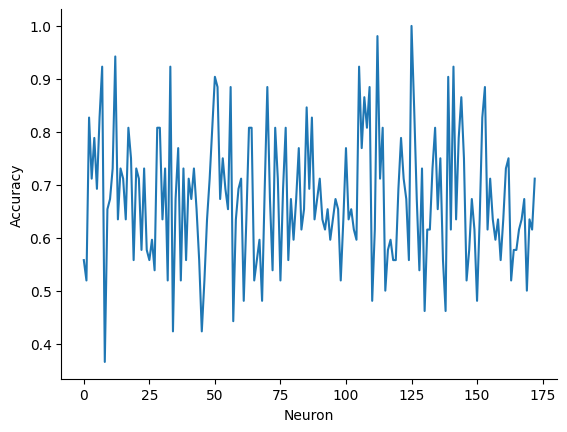

In [28]:
# plot the decoding accuracy of each neuron
plt.plot(np.array(scores))
plt.xlabel('Neuron')
plt.ylabel('Accuracy')
sns.despine()

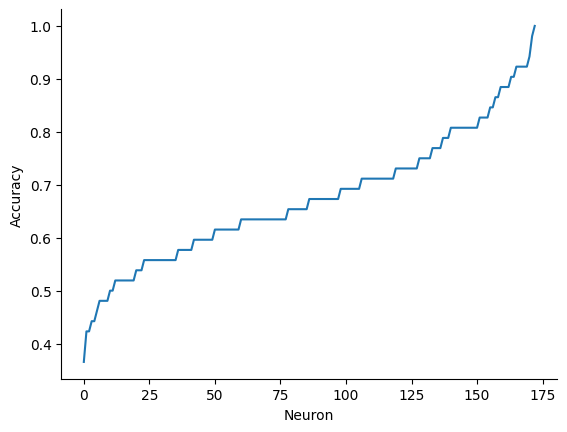

In [ ]:
# that was kind of ugly so let's sort by their accuracy:
plt.plot(np.sort(np.array(scores)))
plt.xlabel('Neuron')
plt.ylabel('Accuracy')
sns.despine()

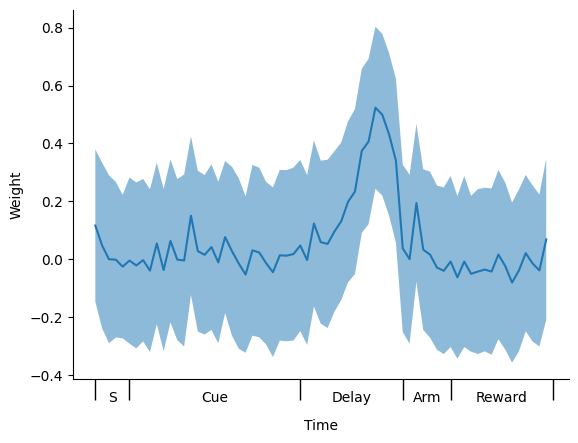

In [29]:
# let's look at one of the weights of the neurons with high accuracy

# first sort the neurons by their accuracy
sorted_idx = np.argsort(np.array(scores))[::-1]

neuron = sorted_idx[5] # here we're choosing the 6th-most accurate neuron. You can change this value to examine other neurons.

# grab the logistic regression result of that neuron
weights = results[neuron].coef_.squeeze()

# grab the standard deviation of the weights
std = stds[neuron]

# plot the weights + credible intervals (our confidence in the weights)
plt.fill_between(np.arange(weights.size-1), weights[:-1] - 2*std[:-1], weights[:-1] + 2*std[:-1], alpha=0.5)
plt.plot(weights[:-1])
plt.xlabel('Time')
plt.ylabel('Weight')

trial_xticks(plt.gca())
sns.despine()


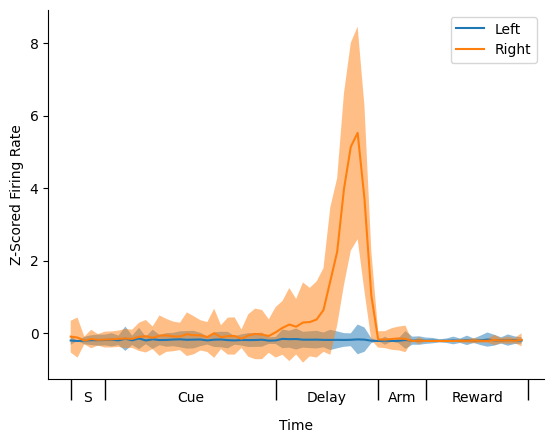

In [30]:
# let's looks at what that neuron's firing rate looks like on left and right trials
left_trials = fr_z[:, data['choice'] == 0, :] # remember, fr_z is a normalized (z-scored) measure of firing rate
right_trials = fr_z[:, data['choice'] == 1, :]

l_mean = left_trials[neuron].mean(axis=0) # average firing rate over time for this neuron across all left trials
r_mean = right_trials[neuron].mean(axis=0)
l_std = left_trials[neuron].std(axis=0) # standard deviation of firing rate over time for this neuron across trials
r_std = right_trials[neuron].std(axis=0)

plt.plot(l_mean, label='Left')
plt.fill_between(np.arange(l_mean.size), l_mean - l_std, l_mean + l_std, alpha=0.5)
plt.plot(r_mean, label='Right')
plt.fill_between(np.arange(r_mean.size), r_mean - r_std, r_mean + r_std, alpha=0.5)

plt.legend()
plt.xlabel('Time')
plt.ylabel('Z-Scored Firing Rate')

trial_xticks(plt.gca())
sns.despine()


# Section 5: Figure Ideas/Experimental Questions:
For your figure, you will answer a different question using similar methodologies described above. For example, you could ask:

-Does ability to decode mouse performance (correct vs. incorrect trials) change across trials? How about across neurons? For this question, you would use the variable 'reward' instead of 'choice' as your target variable ('Y'). With this question, you could speculate on what this brain region (dorsal striatum) seems to be primarily be involved in (i.e. choice or reward)?

-Does the ability to decode mouse performance (or choice) depend on difficulty of the trial? For this question, you would separate your data based on more difficult and easier trials. Difficulty is coded in the variable 'nCues_RminusL'.

-Does the ability to decode mouse performance (or choice) depend on whether the neuron you're using as a predictor is left-preferring or right-preferring, as determined by your sorting using a t-test in section 2?

-Do neurons which are highly predictive of choice vary their activity depending on the difficulty of the trial? Or do they just report choice? (you could bin trials into 4-5 levels of difficulty/contrast and plot the average spike rate for each difficulty).
Reminder: difficulty is represented in "nCues_RminusL".



In [ ]:
# Let's decode mouse performance (reward) and then see how our accuracy
# changes as a function of difficulty


# Separate trials that are easy and that are hard
hard_trials = np.argwhere(np.abs(data['nCues_RminusL']) <= 5)
hard_trials = hard_trials.reshape(-1)
easy_trials = np.setdiff1d(np.arange(258), hard_trials)

In [ ]:
easy_trials[:]

In [107]:
scores_easy = []
scores_hard = []

for t in range(n_timepoints):
    # grab the respective time point for each neuron (this is now n_trials x n_neurons)
    X = np.concatenate([i[:, t:(t+1)] for i in data['timeSqueezedFR']], axis=1)
    X[np.isnan(X)] = 0 # make sure we don't have any nans
    X = StandardScaler().fit_transform(X) # z-score each neuron's firing rate
    X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1) # add a bias term

    # Split X and y by easy and hard trials
    X_easy = X[easy_trials]
    X_hard = X[hard_trials]

    y = data['reward']
    y_easy = y[easy_trials]
    y_hard = y[hard_trials]

    # Split easy trials into train and test
    X_train_easy, X_test_easy, y_train_easy, y_test_easy = train_test_split(X_easy, y_easy, test_size=0.2, random_state=42)

    # Fit LR model on easy and 
    lr_easy = LogisticRegressionCV(cv=5, max_iter=1000, penalty='l2')
    lr_easy.fit(X_train_easy, y_train_easy)

    scores_easy.append(lr_easy.score(X_test_easy, y_test_easy))


    X_train_hard, X_test_hard, y_train_hard, y_test_hard = train_test_split(X_hard, y_hard, test_size=0.2, random_state=42)
    lr_hard = LogisticRegressionCV(cv=5, max_iter=1000, penalty='l2')
    lr_hard.fit(X_train_hard, y_train_hard)
    scores_hard.append(lr_hard.score(X_test_hard, y_test_hard))


    # scores is now a measure of our ability to decode our target variable for each of the 67 time bins

KeyboardInterrupt: 

In [92]:
from pytoolsJS.plotting import load_style_sheet
load_style_sheet()

style loaded


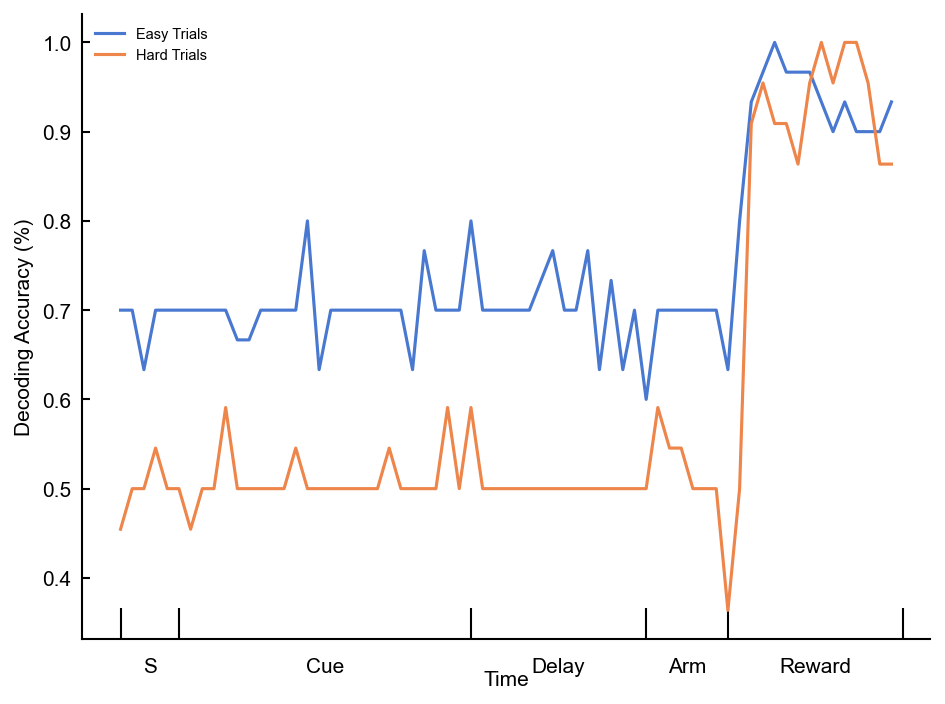

In [97]:
plt.plot(scores_easy, label='Easy Trials')
plt.plot(scores_hard, label='Hard Trials')
plt.ylabel('Decoding Accuracy (%)')
trial_xticks(plt.gca())
plt.legend()

In [157]:
import numpy as np
from sklearn.utils import resample

def balance_within_mask(X, y, mask, *,
                        strategy='downsample',   # 'downsample' | 'upsample'
                        n_per_class=None,        # override target count per class
                        random_state=None,
                        return_indices=False):
    """
    Balance classes inside `mask` by resampling indices per class.

    Parameters
    ----------
    X : array-like or pandas (n_samples, ...)
    y : array-like or pandas (n_samples,)
    mask : boolean array-like (n_samples,)   # subset to balance within
    strategy : {'downsample','upsample'}
    n_per_class : int or None
        If given, each class inside the mask is sampled to this size.
        Otherwise: 'downsample' -> min count, 'upsample' -> max count.
    random_state : int or None
    return_indices : bool
        If True, also return the selected *global* indices.

    Returns
    -------
    X_bal, y_bal  (and idx_bal if return_indices=True)
    """
    # Convert to numpy-friendly forms
    mask = np.asarray(mask, dtype=bool)
    idx_mask = np.flatnonzero(mask)                 # global indices inside mask

    # y within mask
    y_mask = (y.iloc[idx_mask].to_numpy()
              if hasattr(y, "iloc") else np.asarray(y)[idx_mask])

    classes, counts = np.unique(y_mask, return_counts=True)

    if n_per_class is None:
        if strategy == 'downsample':
            target = counts.min()
            replace = False
        elif strategy == 'upsample':
            target = counts.max()
            replace = True
        else:
            raise ValueError("strategy must be 'downsample' or 'upsample'")
    else:
        target = int(n_per_class)
        # upsample if we request more than available in any class
        replace = True

    # For each class, sample *global* indices
    sampled_global_idx = []
    for c in classes:
        idx_c_local = np.flatnonzero(y_mask == c)          # positions within mask
        idx_c_global = idx_mask[idx_c_local]               # map to global indices
        sampled = resample(idx_c_global,
                           replace=replace,
                           n_samples=target,
                           random_state=random_state)
        sampled_global_idx.append(sampled)

    idx_bal = np.concatenate(sampled_global_idx)
    # Optional shuffle to mix classes
    rng = np.random.default_rng(random_state)
    rng.shuffle(idx_bal)

    # Slice X, y according to type
    if hasattr(X, "iloc"):
        X_bal = X.iloc[idx_bal]
    else:
        X_bal = np.asarray(X)[idx_bal]

    if hasattr(y, "iloc"):
        y_bal = y.iloc[idx_bal]
    else:
        y_bal = np.asarray(y)[idx_bal]

    if return_indices:
        return X_bal, y_bal, idx_bal
    return X_bal, y_bal

In [160]:
n_neurons = len(data['timeSqueezedFR'])


scores = []
scores_easy = []
scores_hard = []

for neuron in range(n_neurons):

    # grab the firing rate for each neuron (this is now n_trials x n_timepoints)
    X = data['timeSqueezedFR'][neuron]
    X[np.isnan(X)] = 0 # make sure we don't have any nans
    X = StandardScaler().fit_transform(X) # z-score each neuron's firing rate
    X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1) # add a bias term

    y = data['reward'] # target variable. This can be changed to look at other outcomes, like correct vs. incorrect trials (use 'reward')

    # split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # fit logistic regression model
    lr = LogisticRegressionCV(cv=5, max_iter=2000, penalty='l2', Cs=np.logspace(-4, 4, 10), fit_intercept=False, random_state=10)
    lr.fit(X_train, y_train)
    scores.append(lr.score(X_test, y_test))


    # split data into training and testing sets
    X_train_easy, X_test_easy, y_train_easy, y_test_easy = train_test_split(X[easy_trials], y[easy_trials], test_size=0.2, random_state=42)
    # fit logistic regression model
    lr = LogisticRegressionCV(cv=5, max_iter=2000, penalty='l2', Cs=np.logspace(-4, 4, 10), fit_intercept=False, random_state=10)
    lr.fit(X_train_easy, y_train_easy)
    scores_easy.append(lr.score(X_test_easy, y_test_easy))

    # split data into training and testing sets
    X_train_hard, X_test_hard, y_train_hard, y_test_hard = train_test_split(X[hard_trials], y[hard_trials], test_size=0.2, random_state=42)
    # fit logistic regression model
    lr = LogisticRegressionCV(cv=5, max_iter=2000, penalty='l2', Cs=np.logspace(-4, 4, 10), fit_intercept=False, random_state=10)
    lr.fit(X_train_hard, y_train_hard)
    scores_hard.append(lr.score(X_test_hard, y_test_hard))





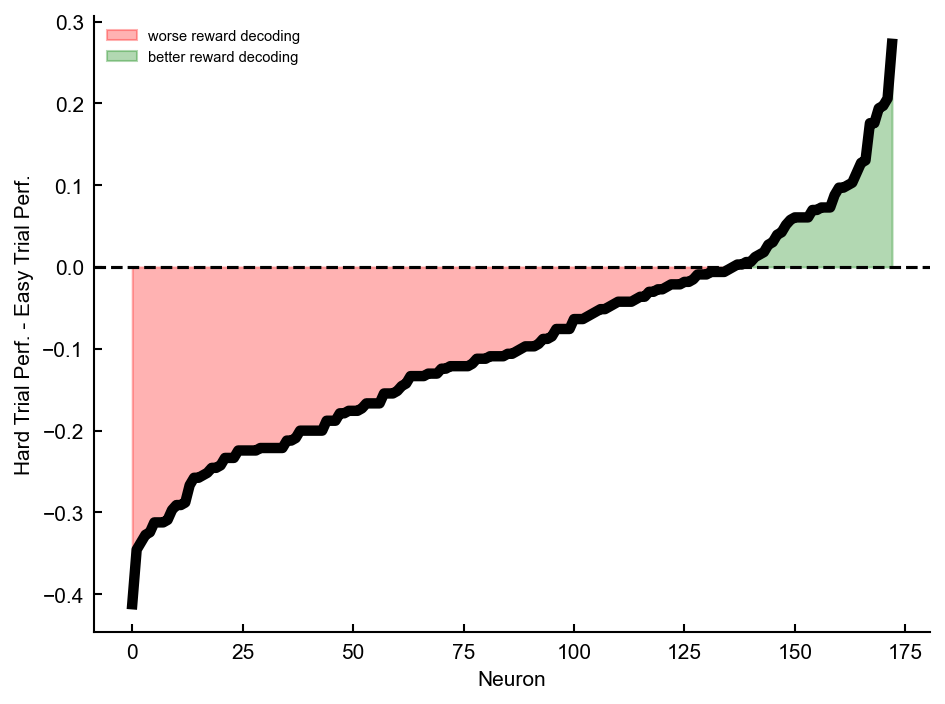

In [161]:
scores, scores_easy, scores_hard = np.array(scores), np.array(scores_easy), np.array(scores_hard)

delta_perf = np.sort(scores_hard - scores_easy)
x = np.arange(len(delta_perf))

plt.plot(delta_perf, lw=5,  zorder=2, c='black')
plt.axhline(0, c='black', ls='--')
plt.ylabel('Hard Trial Perf. - Easy Trial Perf.')
plt.xlabel('Neuron')
plt.fill_between(x, delta_perf, 0, where=(delta_perf < 0), color='red', alpha=0.3, label='worse reward decoding')
plt.fill_between(x, delta_perf, 0, where=(delta_perf > 0), color='green', alpha=0.3, label='better reward decoding')
plt.legend()
